In [434]:
import torch
from spikingjelly.activation_based import neuron, base, surrogate
import matplotlib.pyplot as plt
from typing import Callable, Optional

In [435]:
import os, pandas as pd

In [436]:
src_file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'

df = pd.read_csv(src_file_path)
data = df.iloc[737:937, 0].values

In [437]:
input = torch.zeros([200])
input[50:150] = 0.5

In [438]:
input = torch.from_numpy(data).float()
# input normalization mean-std
mean = input.mean()
std = input.std()
input = (input - mean) / std

In [439]:
sa_i = neuron.SimpleLIFNode(tau=2., decay_input=True, step_mode='s', v_threshold=0.2)
#neuron.v_threshold = torch.ones([200]) * 1.
#neuron.v_threshold[100:] = 0.5
fa_i = neuron.SimpleLIFNode(tau=2., decay_input=False, step_mode='s', v_threshold=0.5)

In [440]:
out_seq = []
fa_i_seq = []
v_seq = []
fa_i_v_seq = []
input = input.unsqueeze(1)  # Reshape input to match expected dimensions
delta_input = torch.zeros_like(input)
delta_input[1:] = input[1:] - input[:-1]  # Calculate delta input
delta_input[0] = input[0]  # Set the first delta input to the first input value
delta_input = torch.abs(delta_input)  # Use absolute value for delta input
adapt_strength = 0.05  # Define the adaptation strength
recovery_strength = 0.02  # Define the recovery strength
adapt_strength_rec = [adapt_strength]
for i in range(200):
    output = sa_i(input[i])
    fa_i_output = fa_i(delta_input[i])
    out_seq.append(output)
    fa_i_seq.append(fa_i_output)
    v_seq.append(sa_i.v)
    fa_i_v_seq.append(fa_i.v)

    spike_indices = torch.nonzero(output, as_tuple=False).squeeze()
        
    if spike_indices.numel() > 0 and (i + 1) < input.size(0):
        # make sure spike_indices is 1-D
        spike_indices = spike_indices.view(-1)

        # decrease only the positions that spiked at the current step
        input[i + 1] -= adapt_strength

        adapt_strength *= 1.5
        print(f"Step {i}, Adaptation Strength: {adapt_strength:.4f}")
        adapt_strength = min(adapt_strength, 10.)  # Cap the adaptation strength

    else:
        # Gradual recovery if there are no spikes
        adapt_strength = max(adapt_strength - recovery_strength, 0.05)

    adapt_strength_rec.append(adapt_strength)
        

out_seq = torch.stack(out_seq)
v_seq = torch.stack(v_seq)
fa_i_seq = torch.stack(fa_i_seq)
fa_i_v_seq = torch.stack(fa_i_v_seq)
v_threshold_seq = sa_i.v_threshold

Step 102, Adaptation Strength: 0.0750
Step 103, Adaptation Strength: 0.1125
Step 104, Adaptation Strength: 0.1688
Step 105, Adaptation Strength: 0.2531
Step 106, Adaptation Strength: 0.3797
Step 107, Adaptation Strength: 0.5695
Step 108, Adaptation Strength: 0.8543
Step 109, Adaptation Strength: 1.2814
Step 110, Adaptation Strength: 1.9222
Step 111, Adaptation Strength: 2.8833
Step 112, Adaptation Strength: 4.3249
Step 113, Adaptation Strength: 6.4873
Step 116, Adaptation Strength: 9.6710


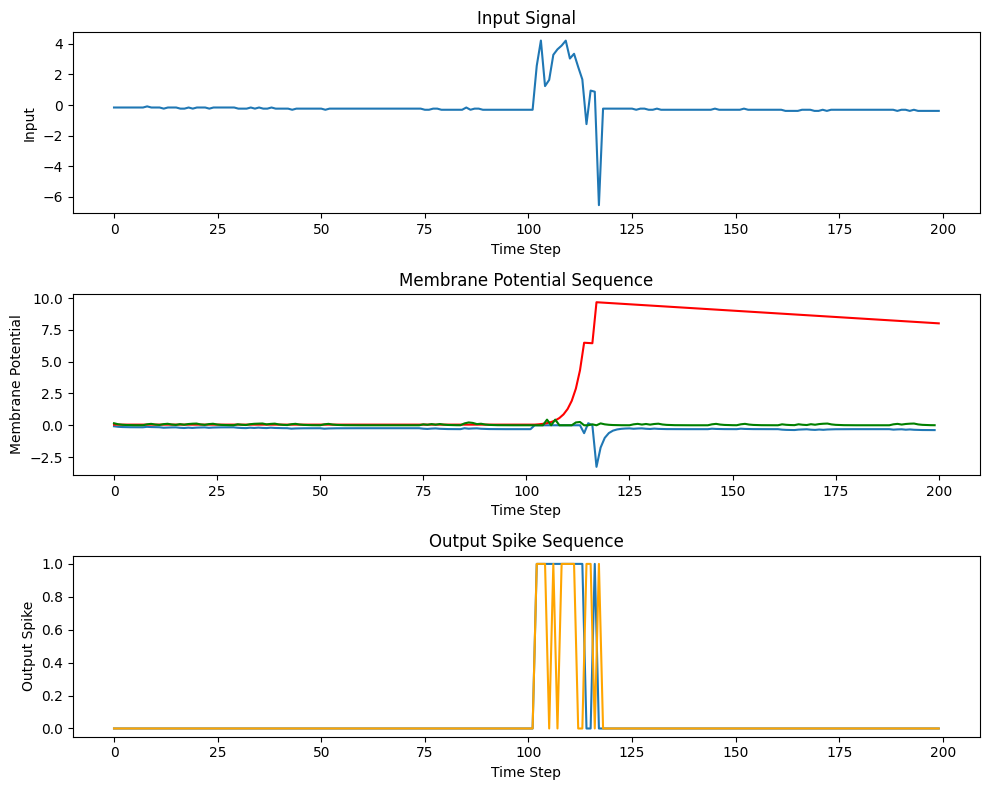

In [441]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
# 0: input
axes[0].plot(input.numpy())
axes[0].set_title('Input Signal')
axes[0].set_ylabel('Input')
axes[0].set_xlabel('Time Step')

# 1: v_seq
axes[1].plot(v_seq.numpy())
axes[1].set_title('Membrane Potential Sequence')
axes[1].set_ylabel('Membrane Potential')
axes[1].set_xlabel('Time Step')

axes[1].plot(adapt_strength_rec, color='red', label='Adaptation Strength')
axes[1].plot(fa_i_v_seq.numpy(), color='green', label='FA I Membrane Potential')

# 2: output
axes[2].plot(out_seq.numpy())
axes[2].set_title('Output Spike Sequence')
axes[2].set_ylabel('Output Spike')
axes[2].set_xlabel('Time Step')

axes[2].plot(fa_i_seq.numpy(), color='orange', label='FA I Output Spike')

plt.tight_layout()
plt.show()